In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pydicom
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread
import glob
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
from torchvision.models import alexnet

%matplotlib inline

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
# convert pathology values to 0,1, or 2
label_encoder = LabelEncoder()

# Get labels from images
def get_label_dict(df_info, test=False):
    # Just want the 1st part from the image path
    df_info['image_path_base_dir'] = df_info['image file path'].apply(lambda x: x[:x.find('/')])
    if test:
        df_info['pathlogy_label'] = label_encoder.transform(df_info['pathology'])
    else:
        df_info['pathlogy_label'] = label_encoder.fit_transform(df_info['pathology'])
    # key-value => image_path: pathology_value (eg malignant or benign)
    label_dict = pd.Series(df_info['pathlogy_label'].values,index=df_info['image_path_base_dir']).to_dict()
    return label_dict
    
df_train_info = pd.read_csv('Mass-Full-Images_CBIS-DDSM/mass_case_description_train_set.csv')
df_test_info = pd.read_csv('Mass-Full-Images_CBIS-DDSM/mass_case_description_test_set.csv')

train_label_dict = get_label_dict(df_train_info)
test_label_dict = get_label_dict(df_test_info, test=True)

In [3]:
train_root_path = 'Mass-Full-Images_CBIS-DDSM/Training'
test_root_path = 'Mass-Full-Images_CBIS-DDSM/Test'
train_filenames = glob.glob(os.path.join('Mass-Full-Images_CBIS-DDSM/Training', '**', '*.dcm'), recursive=True)
test_filenames = glob.glob(os.path.join('Mass-Full-Images_CBIS-DDSM/Test', '**', '*.dcm'), recursive=True)

# This has already been run once and is thus commented out
# Don't want to run it multiple times

# with h5py.File('ddsm_data.hdf5', mode='w') as hdf5_file:
#     hdf5_file.create_dataset("train_data", (len(train_filenames), 224, 224), np.float64)
#     hdf5_file.create_dataset("train_labels", (len(train_filenames),), np.int32)
#     hdf5_file.create_dataset("test_data", (len(test_filenames), 224, 224), np.float64)
#     hdf5_file.create_dataset("test_labels", (len(test_filenames),), np.int32)

#     transform = transforms.Compose([transforms.Resize((224, 224)), 
#                                                 transforms.ToTensor(),
#                                                 transforms.Normalize(mean=[0.5], std=[0.5])])

#     for i, fn in enumerate(train_filenames, 0):
#         path_excluding_root_path = fn[len(train_root_path) + 1:]
#         image_path_base_dir = path_excluding_root_path[:path_excluding_root_path.find('\\')]
#         ds = pydicom.read_file(fn)
#         image = Image.fromarray(ds.pixel_array.astype(float))
#         t = transform(image).view(224, 224)
#         label = train_label_dict[image_path_base_dir]
#         hdf5_file["train_data"][i, ...] = t
#         hdf5_file["train_labels"][i] = label
        
#     for i, fn in enumerate(test_filenames, 0):
#         path_excluding_root_path = fn[len(test_root_path) + 1:]
#         image_path_base_dir = path_excluding_root_path[:path_excluding_root_path.find('\\')]
#         ds = pydicom.read_file(fn)
#         image = Image.fromarray(ds.pixel_array.astype(float))
#         t = transform(image).view(224, 224)
#         label = test_label_dict[image_path_base_dir]
#         hdf5_file["test_data"][i, ...] = t
#         hdf5_file["test_labels"][i] = label

# All images (224x224) are now saved in the file
# We will read all images from this file in future

In [4]:
class Dataset_Hdf5(Dataset):

    def __init__(self, path, data_type):
        """ Intialize the dataset
        """
        self.path = path
        self.file = h5py.File(path, 'r')
        self.images = self.file['{}_data'.format(data_type)]
        self.labels = self.file['{}_labels'.format(data_type)]
                
        self.len = self.images.shape[0]
        
    # You must override __getitem__ and __len__
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        # unsqueeze adds dimension to image -> converts to 1x224x224 since we don't have rgb
        return torch.tensor(self.images[index], dtype=torch.float).unsqueeze(0), \
                torch.tensor(self.labels[index], dtype=torch.long)

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

# 64 * [224 * 224], 0

In [5]:
ddms_train_loader = torch.utils.data.DataLoader(Dataset_Hdf5('ddsm_data.hdf5', 'train'), 
                                                batch_size=64, shuffle=True)
ddms_test_loader = torch.utils.data.DataLoader(Dataset_Hdf5('ddsm_data.hdf5', 'test'), 
                                               batch_size=64, shuffle=True)

In [6]:
# Neural network with 1 hidden layer
class DDMS_NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(DDMS_NN, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output
    
# all_train_labels = np.array([], dtype='int64')
# for data in ddms_train_loader:
#     _, labels = data
#     labels = labels.numpy()
#     all_train_labels = np.concatenate((all_train_labels, labels))
# label_counts = np.array(np.unique(all_train_labels, return_counts=True))[1]
# class_weights = torch.tensor(label_counts / np.sum(label_counts), dtype=torch.float32)

ddms_net = DDMS_NN(224*224, 1024, 3) # 3 classes
ddms_criterion = nn.CrossEntropyLoss()
ddms_optimizer = torch.optim.Adam(ddms_net.parameters(), lr=0.01, betas=(0.5, 0.999))

In [7]:
def train(net, train_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            ddms_optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('End of epoch {}, Loss {}'.format(epoch + 1, running_loss / len(train_loader)))

    print('Finished Training')
    
def test(net, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [8]:
train(ddms_net, ddms_train_loader, ddms_criterion, ddms_optimizer, 15)

End of epoch 1, Loss 7133375.685314941
End of epoch 2, Loss 25319.95051269531
End of epoch 3, Loss 1524.5173374652863
End of epoch 4, Loss 699.8593477606773
End of epoch 5, Loss 191.83523521125318
End of epoch 6, Loss 203.67360959351063
End of epoch 7, Loss 293.26965224444865
End of epoch 8, Loss 16.63816164433956
End of epoch 9, Loss 24.149242001771928
End of epoch 10, Loss 35.867157995700836
End of epoch 11, Loss 41.47304390072823
End of epoch 12, Loss 2.9445077747106554
End of epoch 13, Loss 2.533010372519493
End of epoch 14, Loss 1.2018413066864013
End of epoch 15, Loss 1.0596394270658493
Finished Training


In [9]:
test(ddms_net, ddms_test_loader)

Accuracy of the network on the test images: 41 %


In [10]:
# alex_net = alexnet(num_classes=3)
# alex_net.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [11]:
# train(alex_net, ddms_train_loader, ddms_criterion, ddms_optimizer, 10)

In [12]:
# test(alex_net, ddms_test_loader)

In [13]:
log_softmax = nn.LogSoftmax(dim=1)
net = ddms_net

In [14]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [15]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [16]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [17]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(ddms_train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,224*224), data[1])
    normalizer_train = len(ddms_train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  1354971090.070655
Epoch  1  Loss  890328049.3101377
Epoch  2  Loss  732343723.1547033
Epoch  3  Loss  801296877.3276694
Epoch  4  Loss  737383025.9892359


In [18]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(ddms_test_loader):
    images, labels = data
    predicted = predict(images.view(-1,224*224))
    total += labels.size(0)
    correct += (predicted == labels.numpy()).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 40 %


In [19]:
classes = ('BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT')

In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [21]:
num_samples = 10
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,224*224)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [26]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 3, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [23]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(ddms_test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  361
Skipped:  2
Accuracy when made predictions: 41 %


In [24]:
dataiter = iter(ddms_test_loader)
images, labels = dataiter.next()

Real:  0


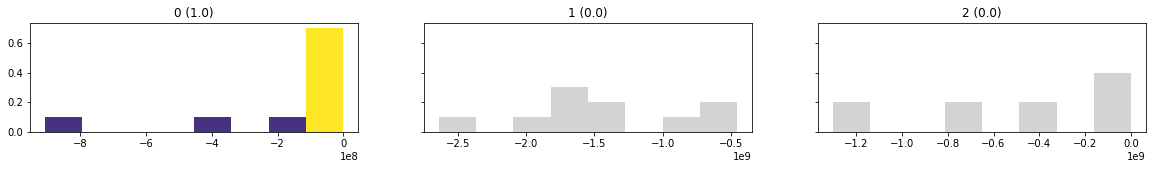

Correct


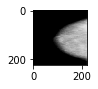

Real:  2


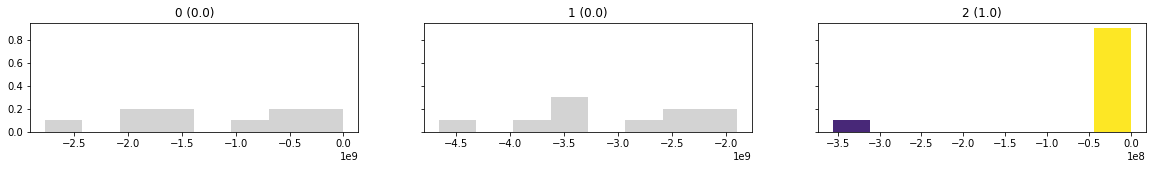

Correct


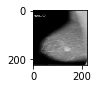

Real:  0


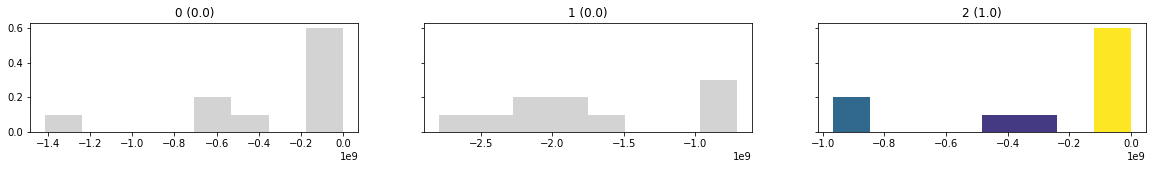

Incorrect :()


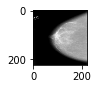

Real:  0


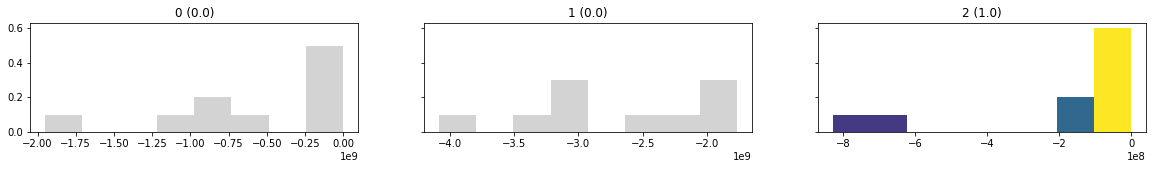

Incorrect :()


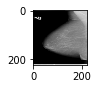

Real:  0


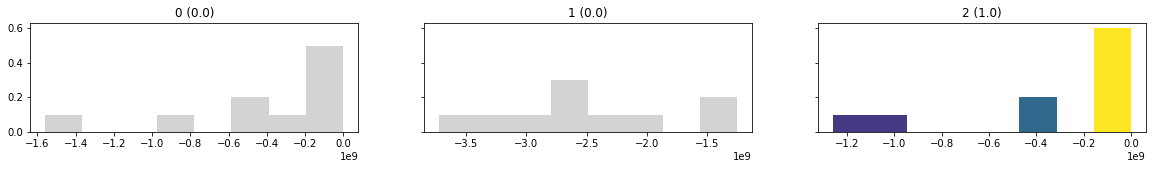

Incorrect :()


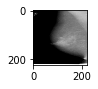

Real:  2


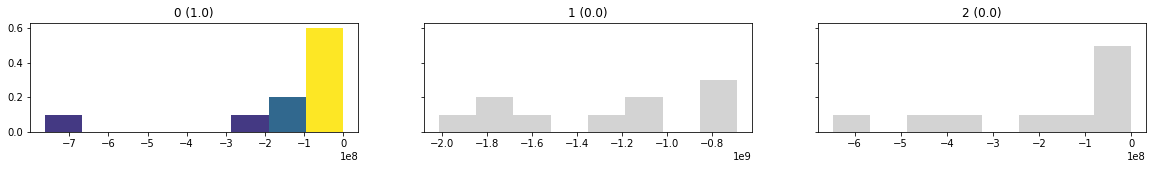

Incorrect :()


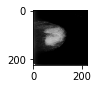

Real:  1


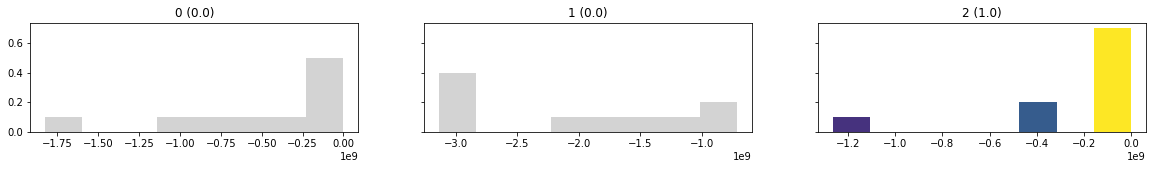

Incorrect :()


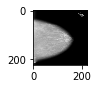

Real:  1


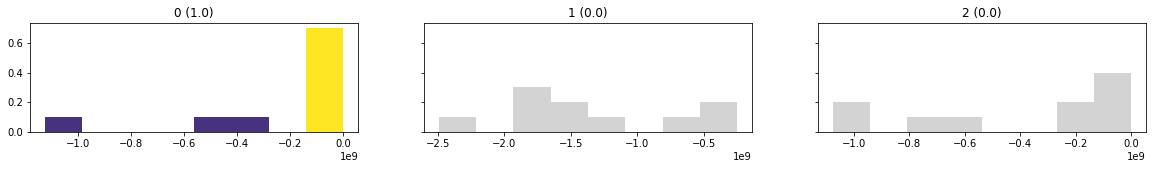

Incorrect :()


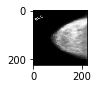

Real:  2


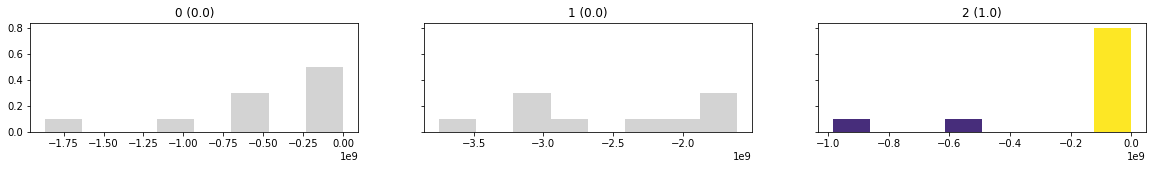

Correct


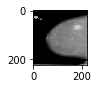

Real:  0


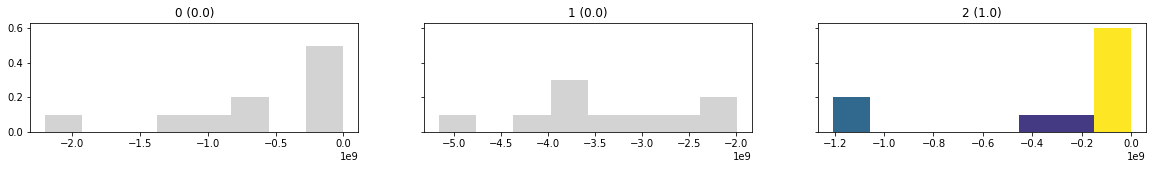

Incorrect :()


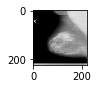

Real:  2


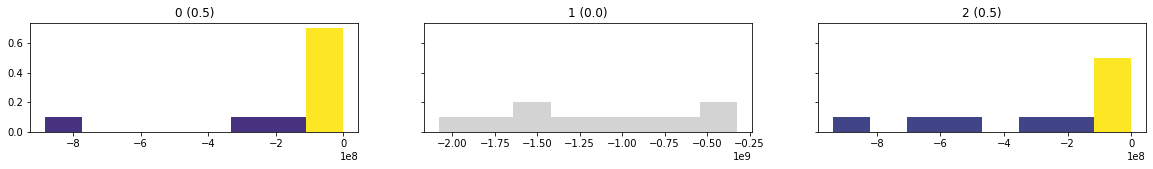

Incorrect :()


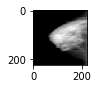

Real:  2


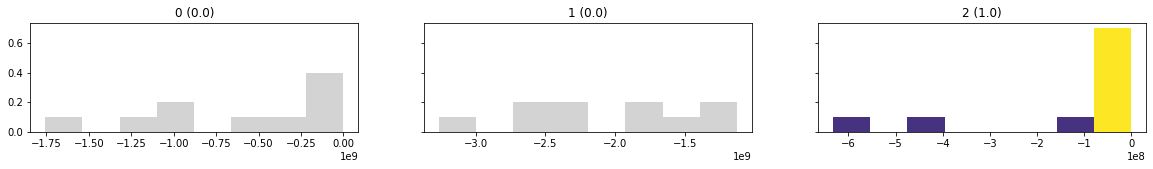

Correct


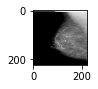

Real:  0


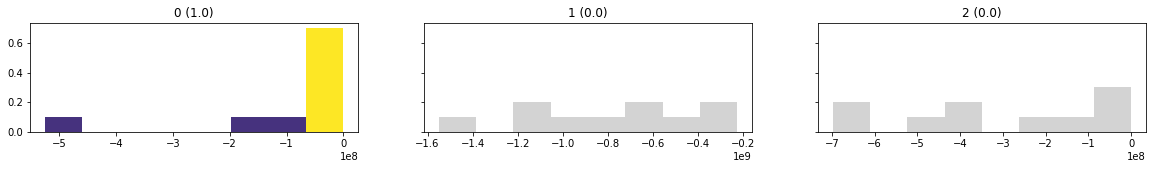

Correct


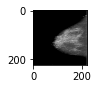

Real:  1


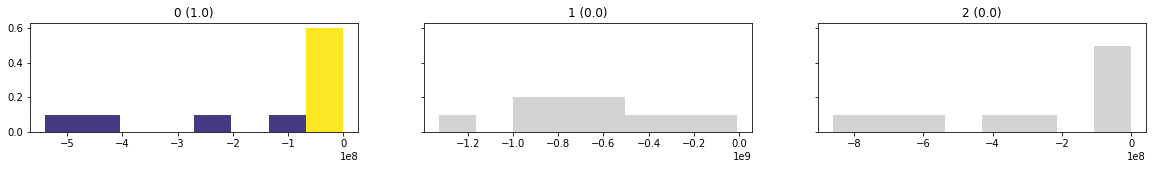

Incorrect :()


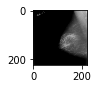

Real:  0


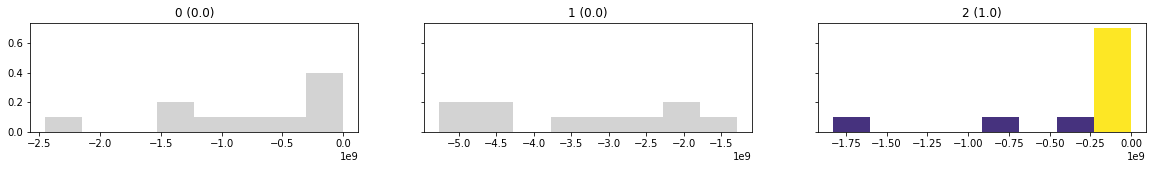

Incorrect :()


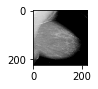

Real:  0


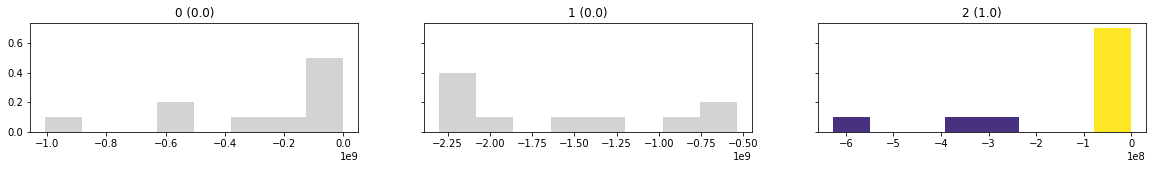

Incorrect :()


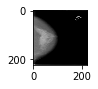

Real:  2


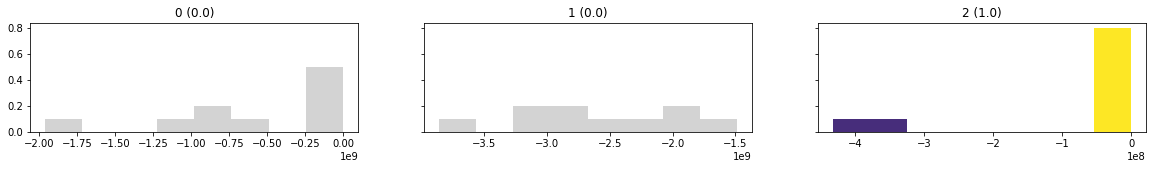

Correct


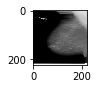

Real:  2


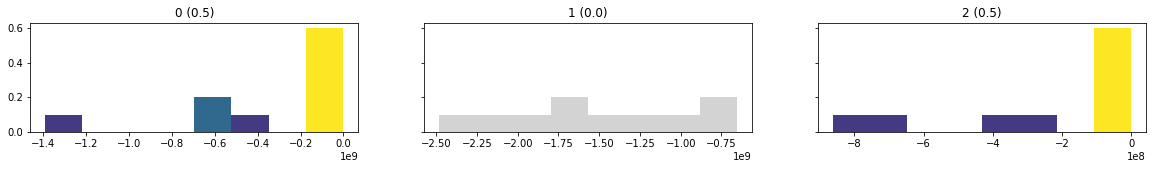

Incorrect :()


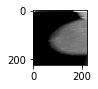

Real:  0


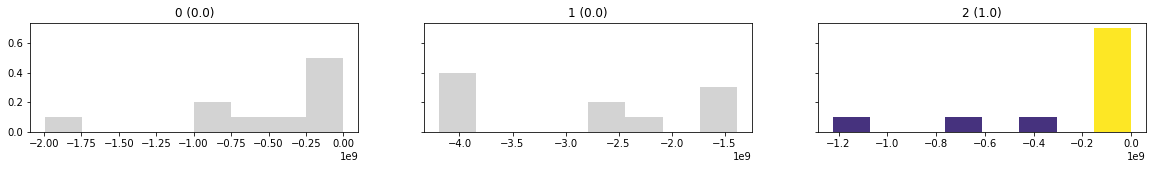

Incorrect :()


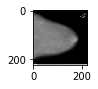

Real:  0


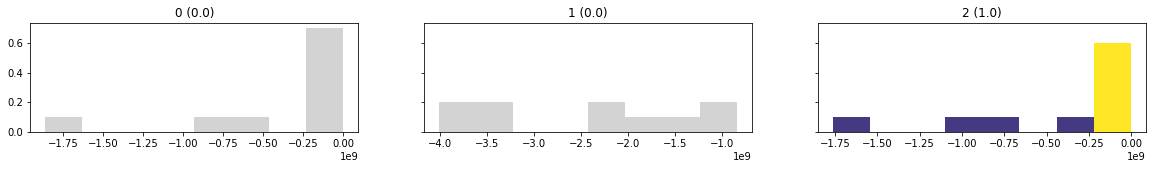

Incorrect :()


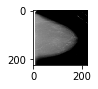

Real:  0


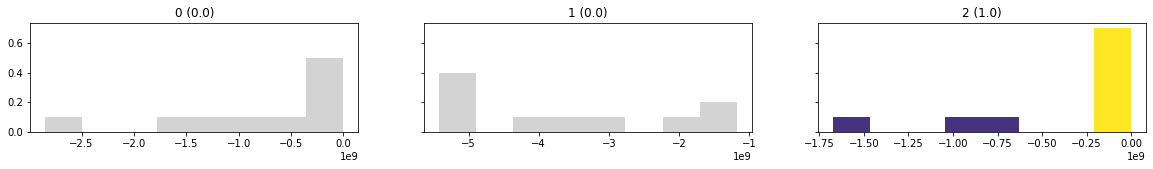

Incorrect :()


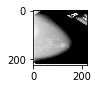

Real:  2


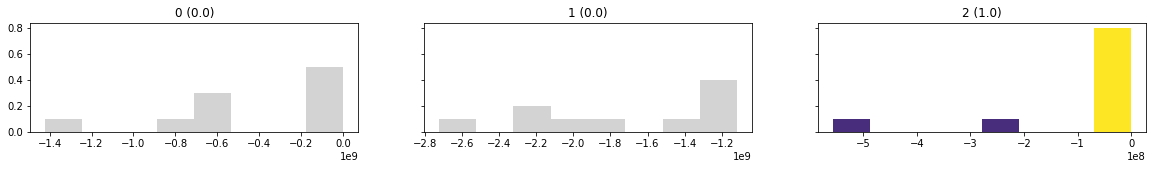

Correct


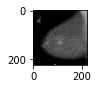

Real:  0


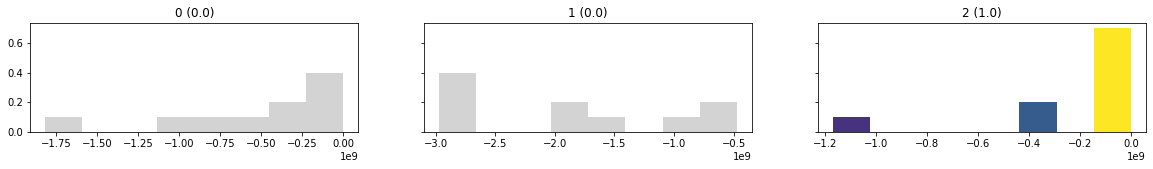

Incorrect :()


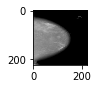

Real:  2


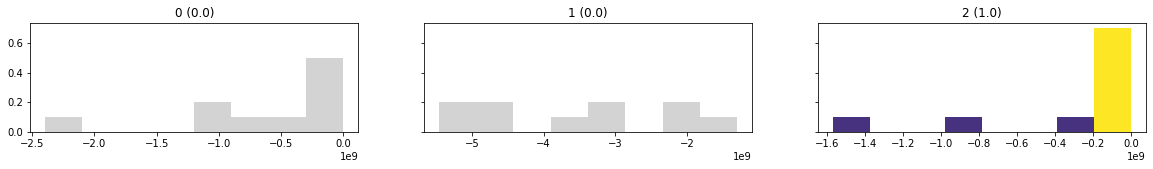

Correct


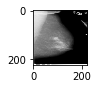

Real:  0


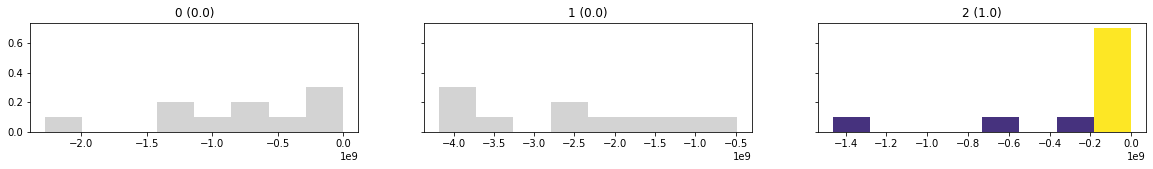

Incorrect :()


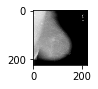

Real:  2


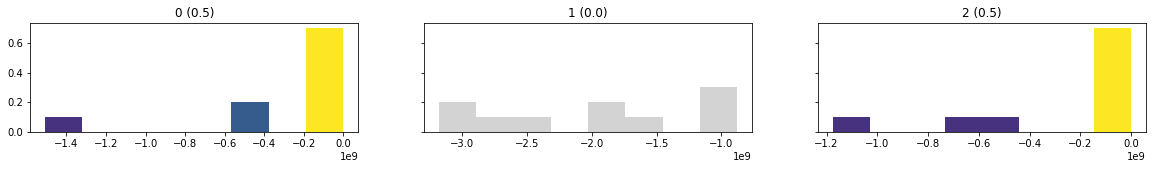

Incorrect :()


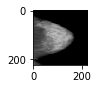

Real:  2


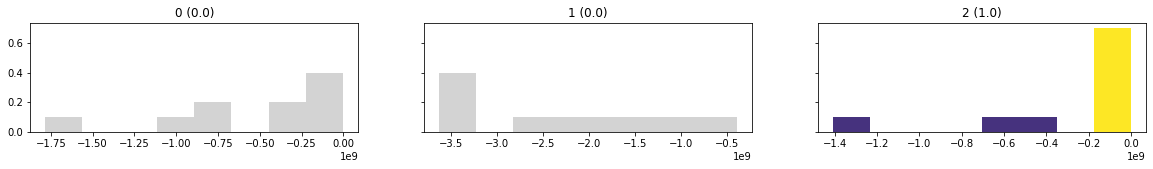

Correct


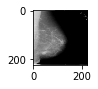

Real:  2


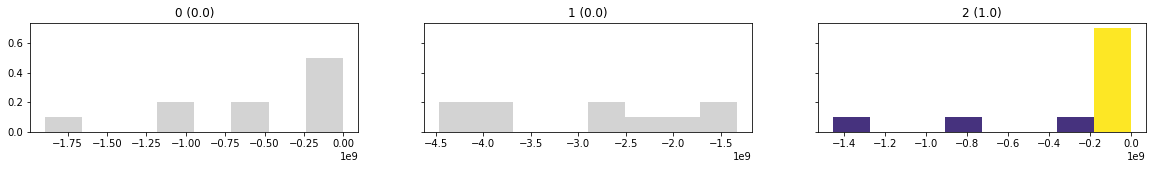

Correct


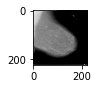

Real:  2


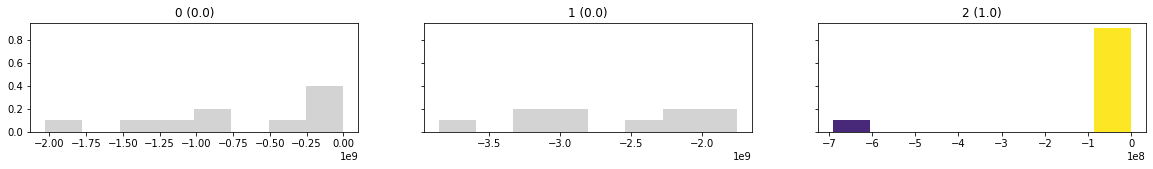

Correct


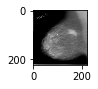

Real:  0


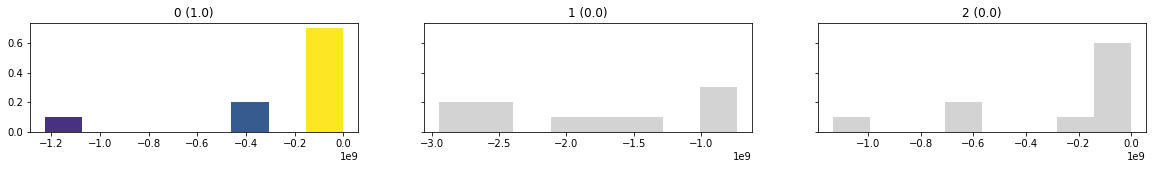

Correct


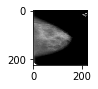

Real:  0


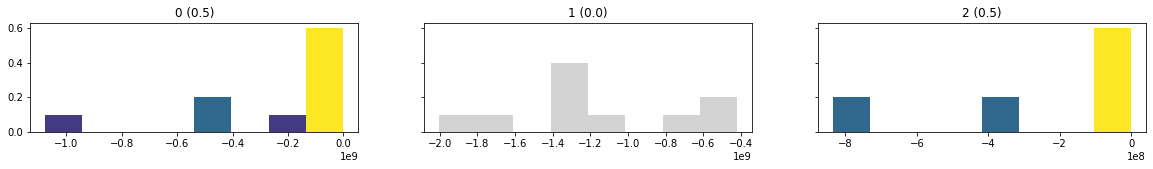

Correct


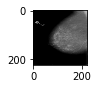

Real:  2


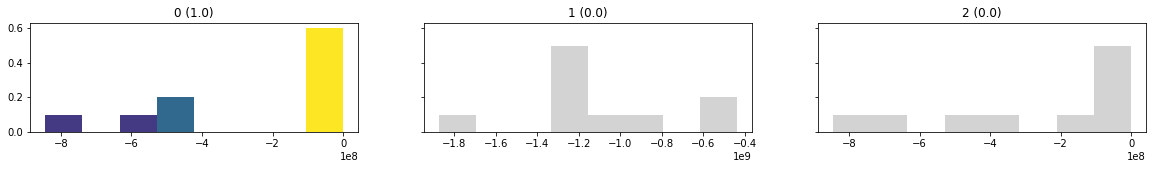

Incorrect :()


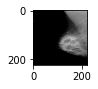

Real:  2


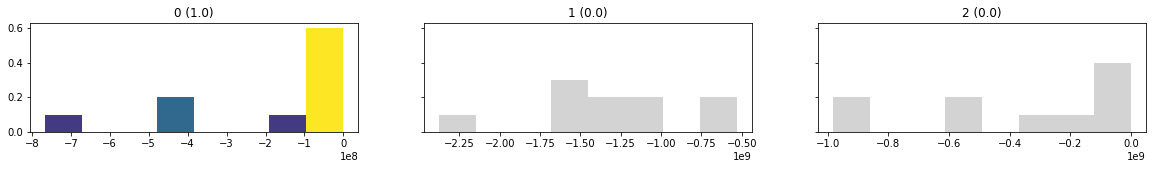

Incorrect :()


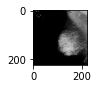

Real:  2


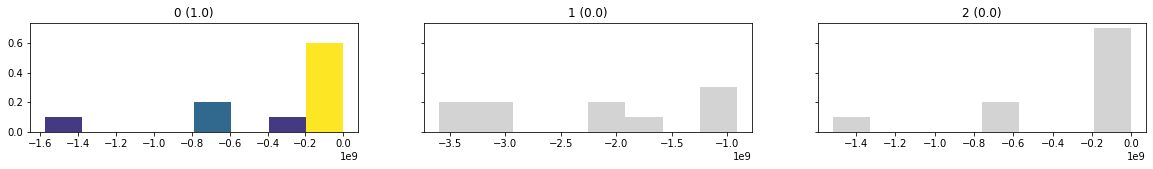

Incorrect :()


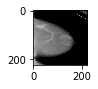

Real:  2


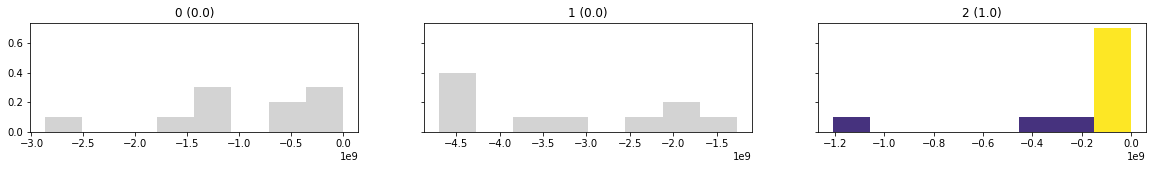

Correct


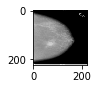

Real:  0


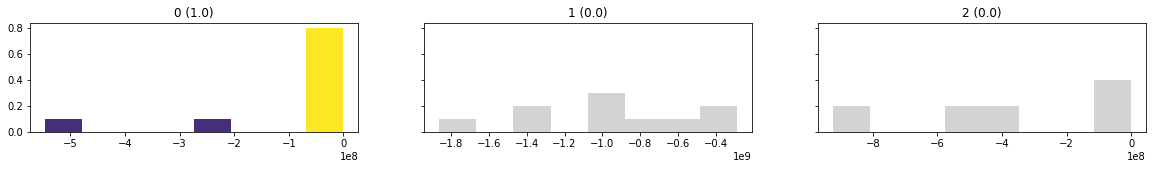

Correct


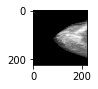

Real:  2


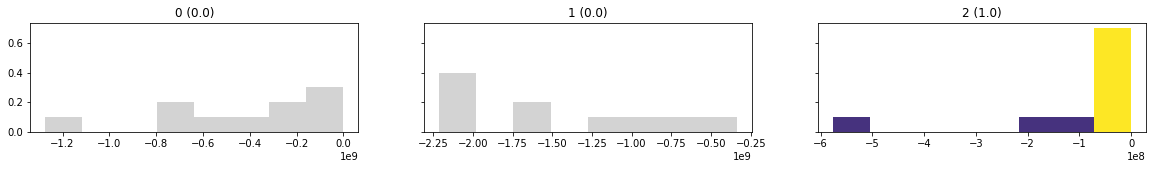

Correct


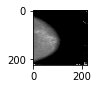

Real:  2


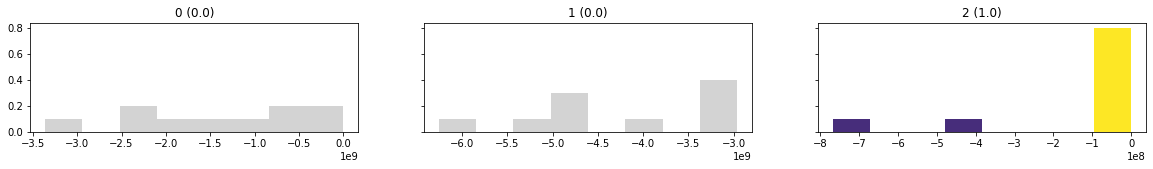

Correct


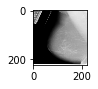

Real:  0


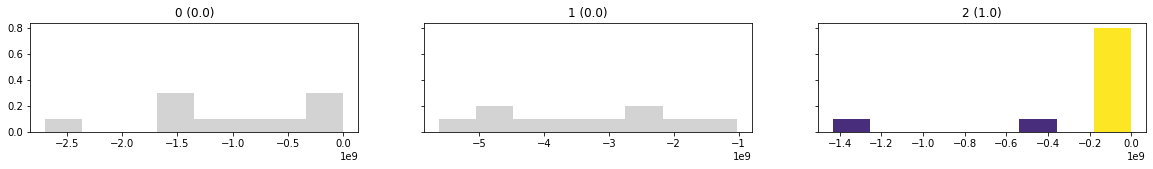

Incorrect :()


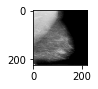

Real:  2


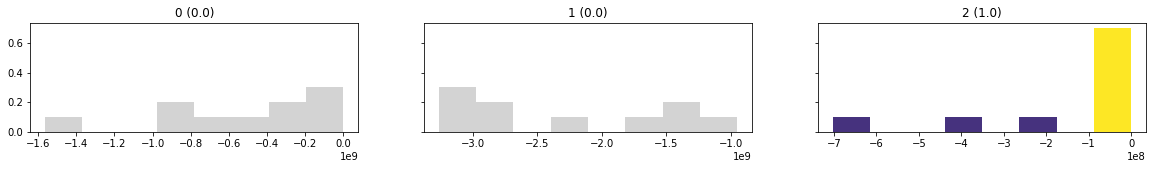

Correct


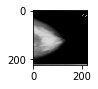

Real:  2


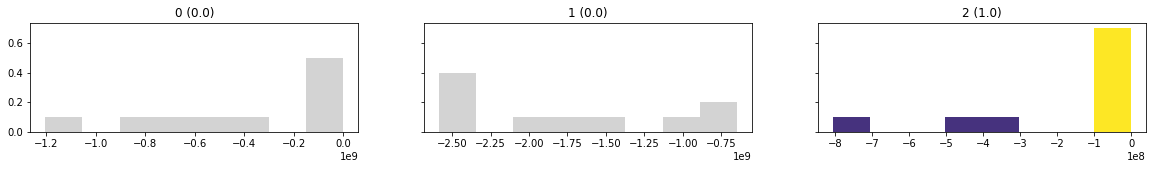

Correct


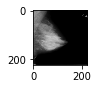

Real:  0


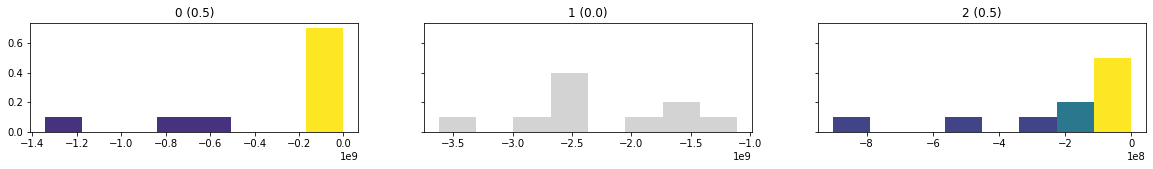

Correct


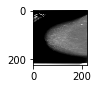

Real:  0


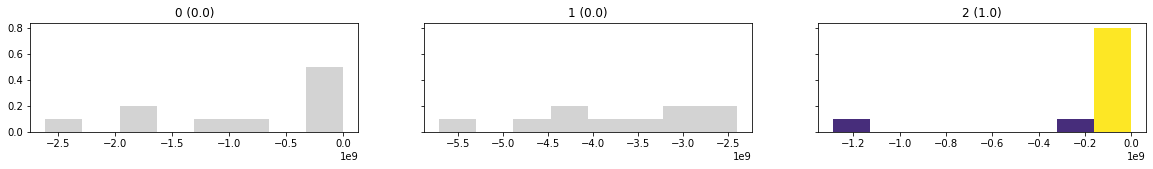

Incorrect :()


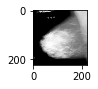

Real:  2


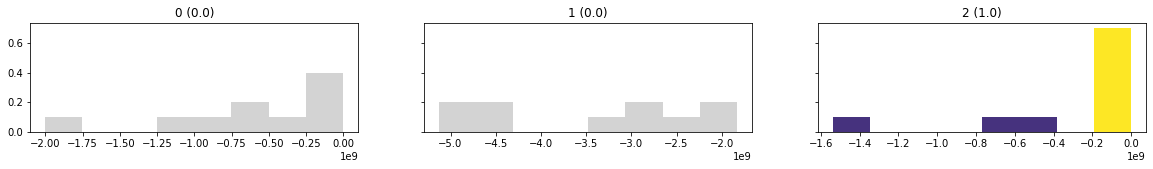

Correct


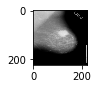

Real:  0


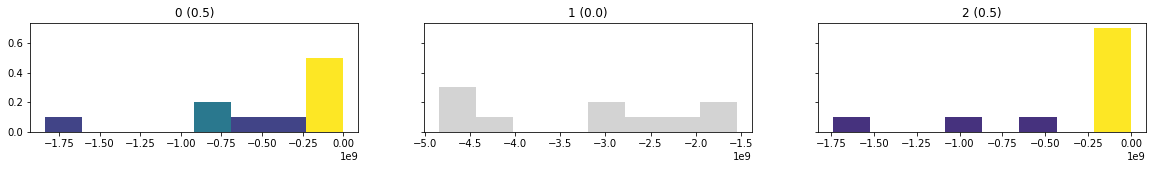

Correct


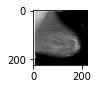

Real:  0


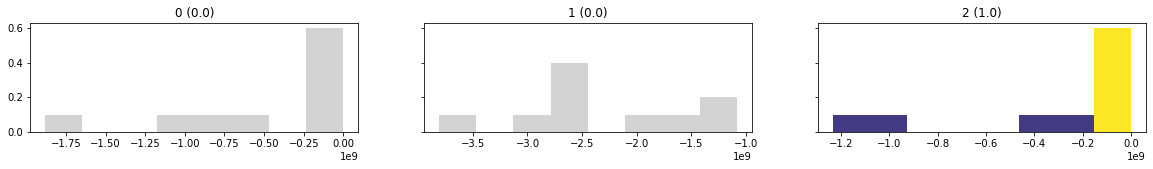

Incorrect :()


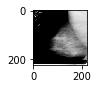

Real:  2


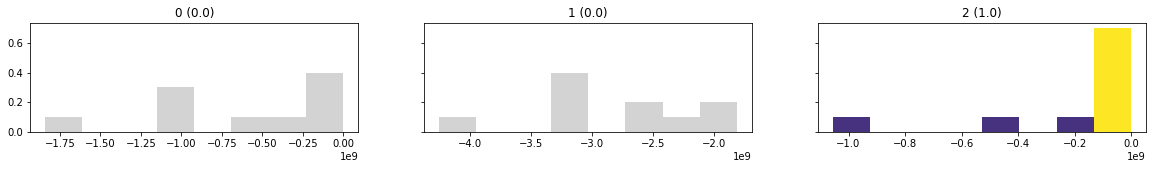

Correct


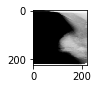

Real:  0


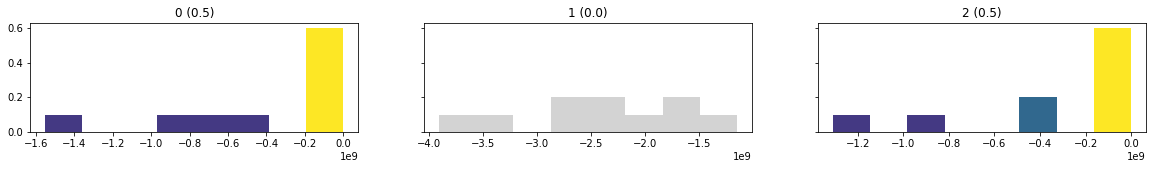

Correct


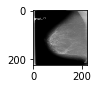

Real:  0


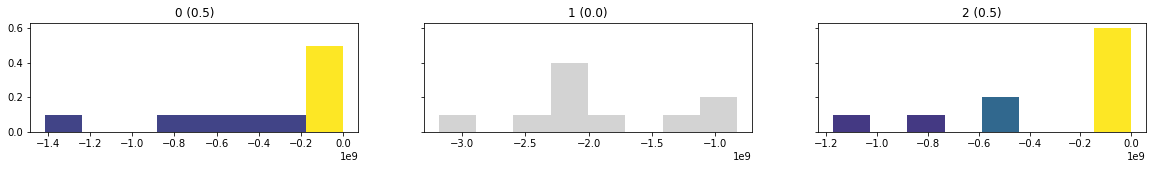

Correct


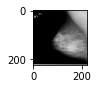

Real:  0


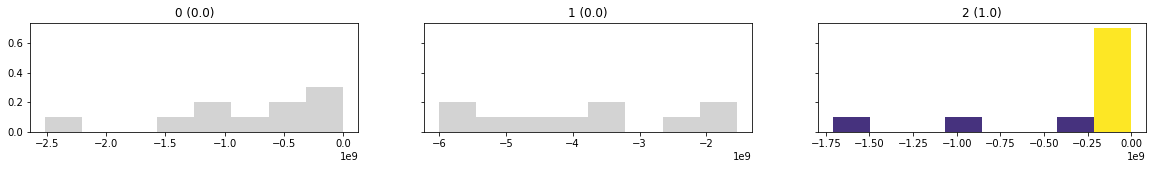

Incorrect :()


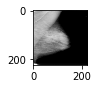

Real:  2


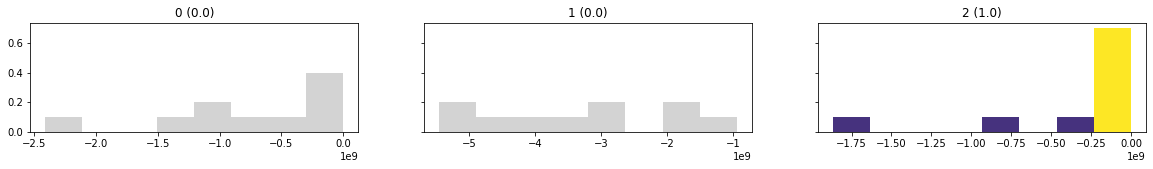

Correct


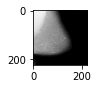

Real:  0


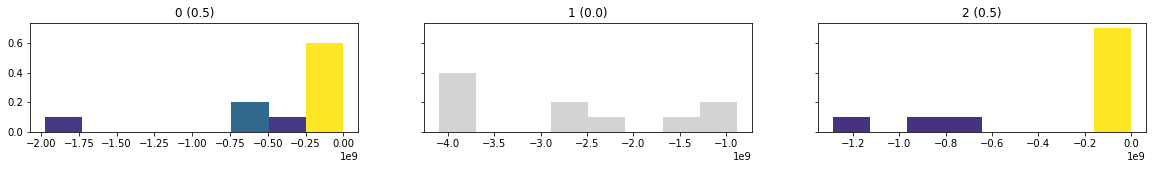

Correct


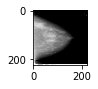

Real:  0


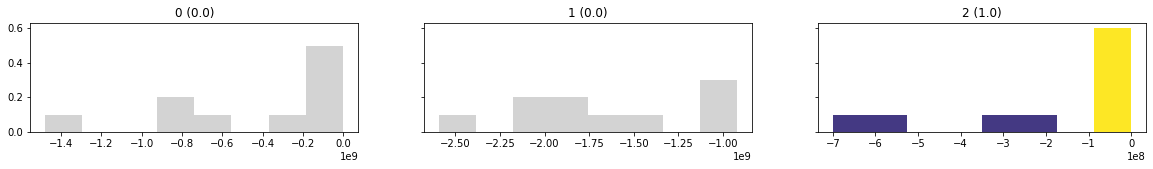

Incorrect :()


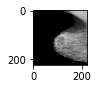

Real:  0


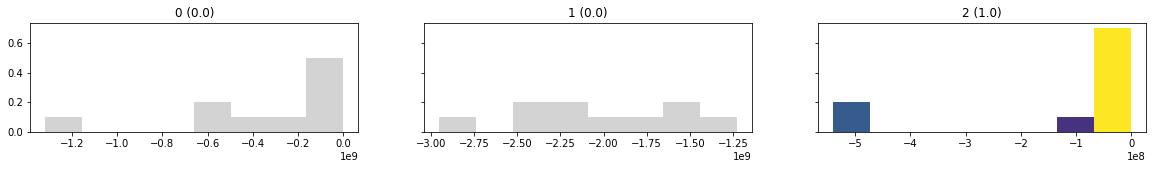

Incorrect :()


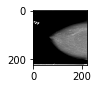

Real:  1


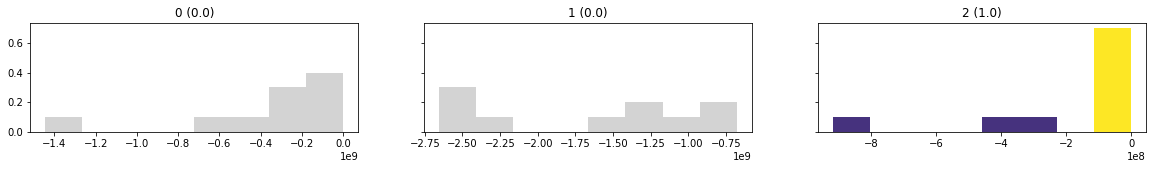

Incorrect :()


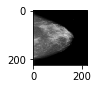

Real:  0


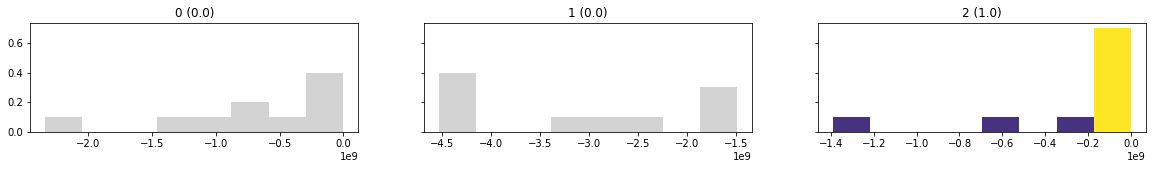

Incorrect :()


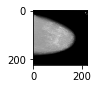

Real:  2


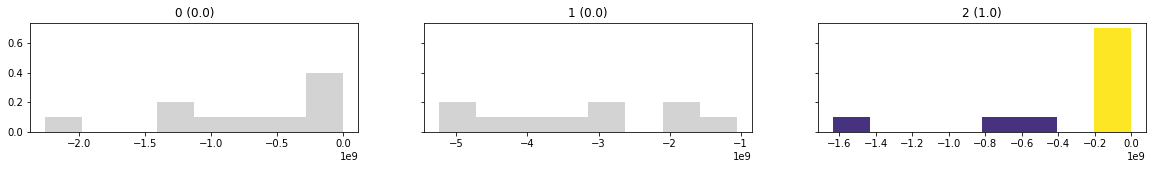

Correct


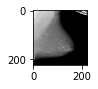

Real:  0


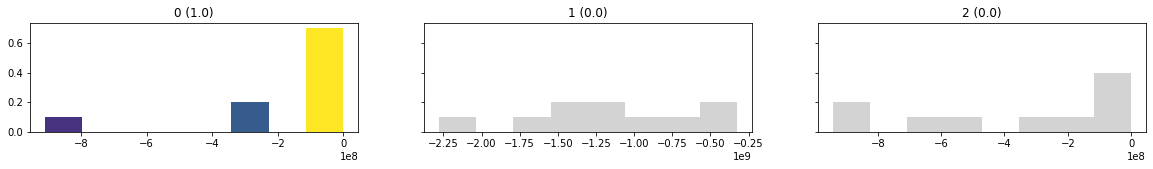

Correct


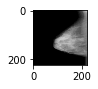

Real:  0


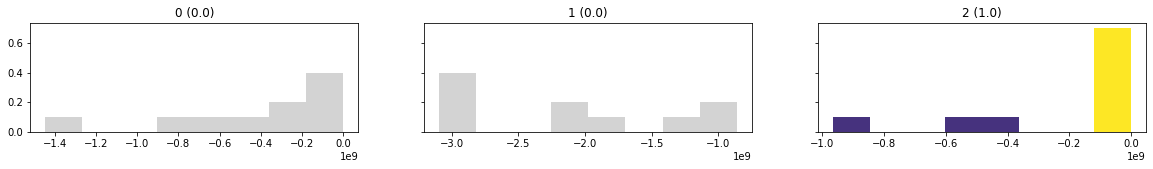

Incorrect :()


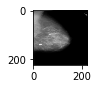

Real:  0


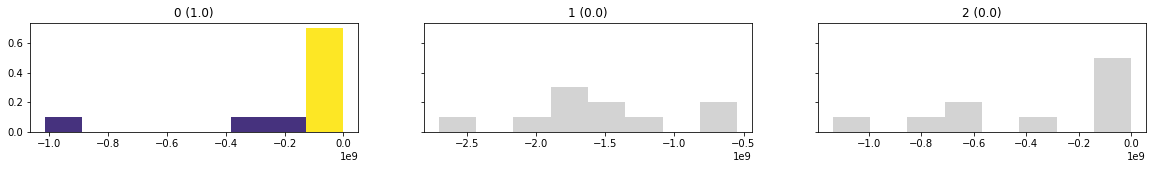

Correct


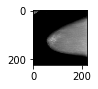

Real:  2


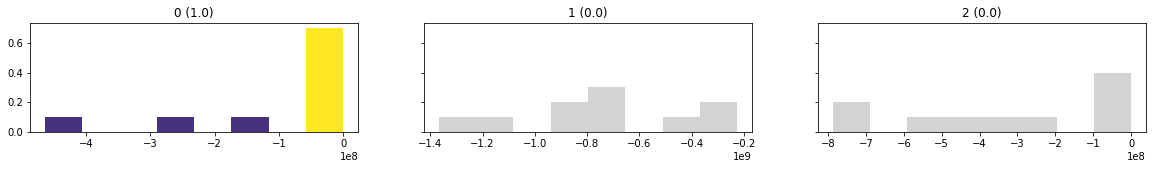

Incorrect :()


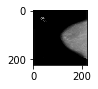

Real:  0


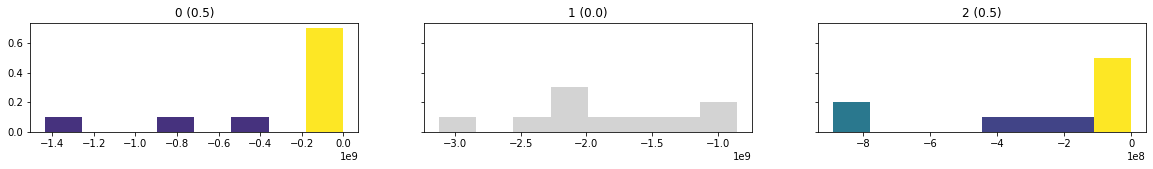

Correct


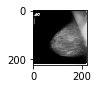

Real:  1


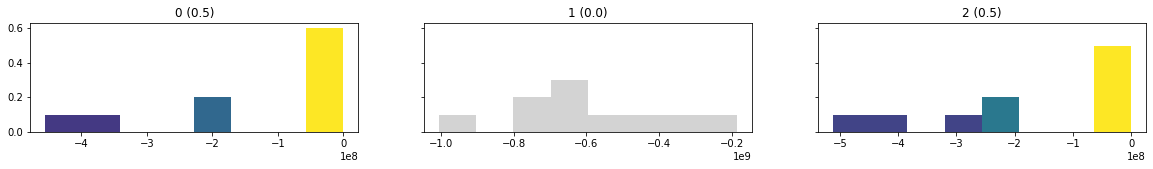

Incorrect :()


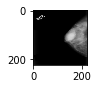

Real:  0


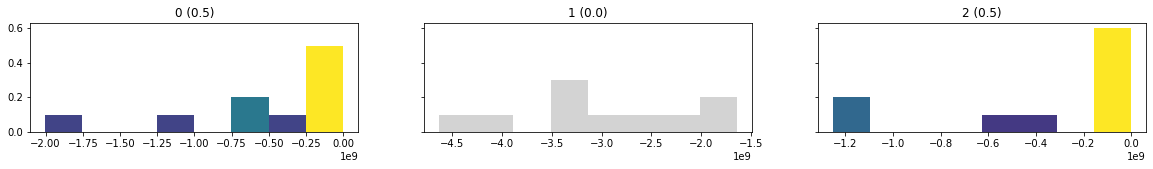

Correct


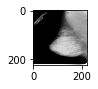

Summary
Total images:  64
Predicted for:  64
Accuracy when predicted:  0.5


(64, 32.0, 64)

In [27]:
test_batch(images[:100], labels[:100])